In [34]:
# Make sure these packages are installed
# pip install yfinance pandas numpy matplotlib seaborn scikit-learn plotly joblib

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib



In [35]:
# Fetch Apple stock data from Yahoo Finance
stock_data = yf.download('AAPL', start='2022-01-01', end='2024-12-31', auto_adjust=True)
stock_data.reset_index(inplace=True)
stock_data.head()


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2022-01-03,178.645660,179.499589,174.425155,174.542932,104487900
1,2022-01-04,176.378342,179.558457,175.809061,179.254190,99310400
2,2022-01-05,171.686707,176.839663,171.411883,176.290017,94537600
3,2022-01-06,168.820663,172.059668,168.467317,169.507721,96904000
4,2022-01-07,168.987503,170.921090,167.868576,169.694195,86709100


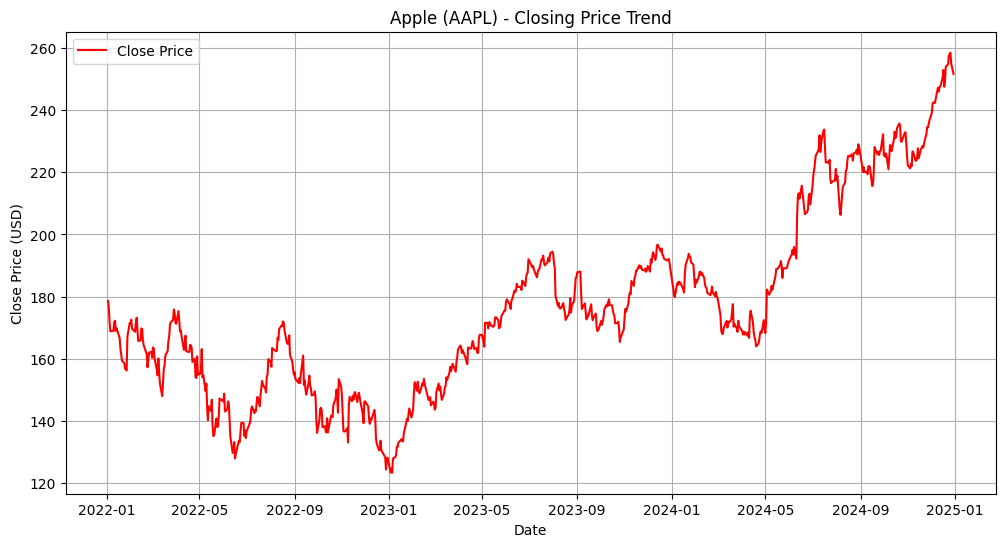

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Date'], stock_data['Close'], color='red', label='Close Price')
plt.title('Apple (AAPL) - Closing Price Trend')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.legend()
plt.show()


In [38]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(
    x=stock_data['Date'],
    open=stock_data['Open'],
    high=stock_data['High'],
    low=stock_data['Low'],
    close=stock_data['Close']
)])
fig.update_layout(title='AAPL Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Stock Price (USD)')
fig.show()


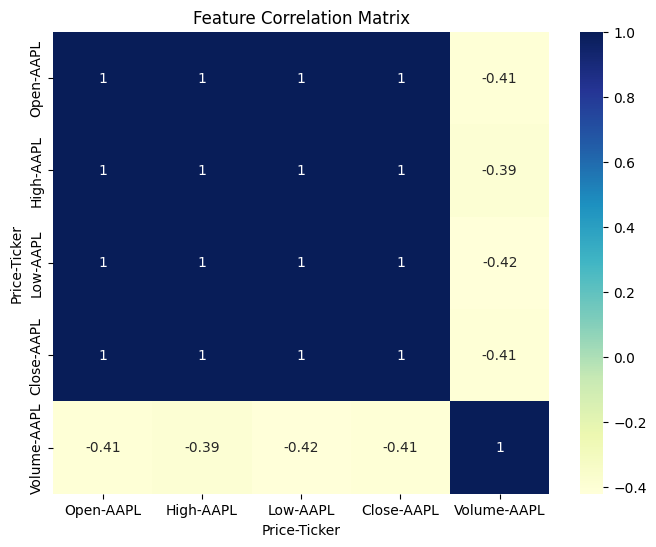

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='YlGnBu')
plt.title('Feature Correlation Matrix')
plt.show()


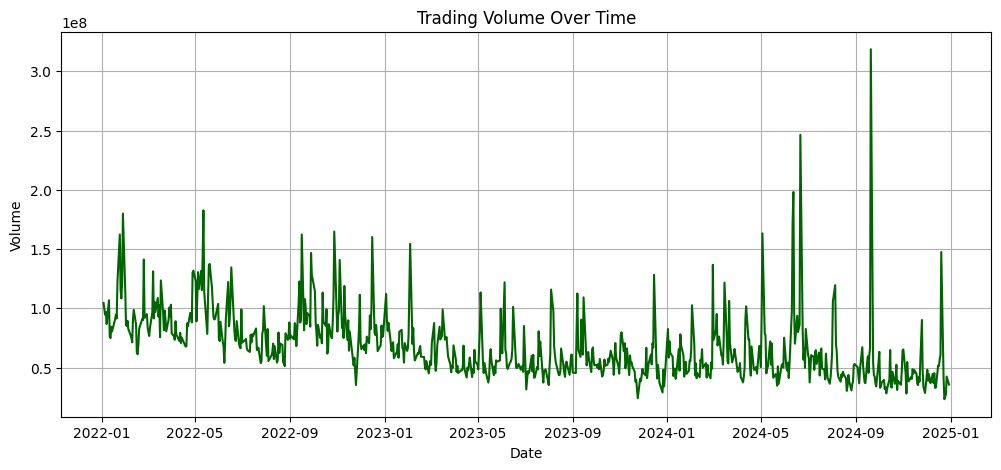

In [40]:
plt.figure(figsize=(12, 5))
plt.plot(stock_data['Date'], stock_data['Volume'], color='darkgreen')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()


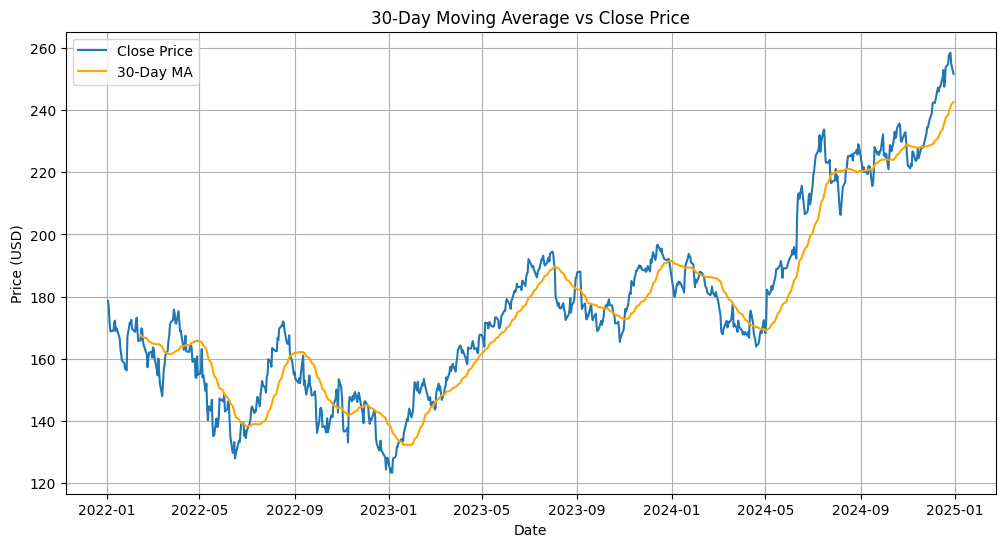

In [41]:
stock_data['MA_30'] = stock_data['Close'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price')
plt.plot(stock_data['Date'], stock_data['MA_30'], label='30-Day MA', color='orange')
plt.title('30-Day Moving Average vs Close Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
stock_data['Next_Close'] = stock_data['Close'].shift(-1)
stock_data['Daily_Return'] = stock_data['Close'].pct_change()
stock_data['MA_7'] = stock_data['Close'].rolling(window=7).mean()
stock_data['MA_21'] = stock_data['Close'].rolling(window=21).mean()
stock_data['Volatility'] = stock_data['Close'].rolling(window=7).std()

stock_data.dropna(inplace=True)
stock_data.set_index('Date', inplace=True)
stock_data.head()


Price,Close,High,Low,Open,Volume,MA_30,Next_Close,Daily_Return,MA_7,MA_21,Volatility
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2022-02-14,165.969543,166.657477,163.689519,164.485557,86185500,167.738231,169.812134,0.001423,169.148084,165.975453,2.766381
2022-02-15,169.812134,169.969380,167.315915,168.023507,62527400,167.443780,169.576263,0.023152,169.204239,165.972654,2.776768
2022-02-16,169.576263,170.352642,167.119349,168.888330,61177400,167.217044,165.969543,-0.001389,169.329189,166.111459,2.770052
2022-02-17,165.969543,168.947324,165.566606,168.082485,69589300,167.026472,164.416779,-0.021269,168.493838,166.245374,2.776462
2022-02-18,164.416779,167.600931,163.325908,166.893353,82772700,166.879676,161.488144,-0.009356,167.233093,166.385738,2.206188


In [43]:
# Define predictors and target
feature_cols = ['Open', 'High', 'Low', 'Volume', 'Daily_Return', 'MA_7', 'MA_21', 'Volatility']
X = stock_data[feature_cols]
y = stock_data['Next_Close']

# Drop the last row if NaN appears in target
X = X[:-1]
y = y[:-1]


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [45]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [46]:
y_pred = rf_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error (MSE): 10.77
R² Score: 0.99


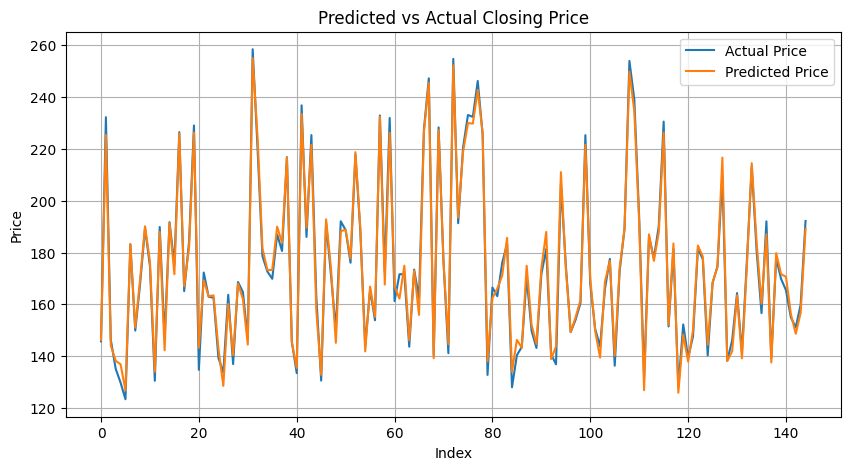

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Predicted vs Actual Closing Price')
plt.xlabel('Index')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()


In [48]:
joblib.dump(rf_model, 'aapl_rf_model.pkl')
joblib.dump(scaler, 'aapl_scaler.pkl')


['aapl_scaler.pkl']

In [49]:
# Reload model and scaler
model = joblib.load('aapl_rf_model.pkl')
scaler = joblib.load('aapl_scaler.pkl')

# New stock input features
new_input = pd.DataFrame([{
    'Open': 170.12,
    'High': 172.50,
    'Low': 169.80,
    'Volume': 68903400,
    'Daily_Return': 0.0025,
    'MA_7': 171.0,
    'MA_21': 169.5,
    'Volatility': 0.018
}])

# Transform input
scaled_input = scaler.transform(new_input.values)

# Predict next closing price
predicted_price = model.predict(scaled_input)
print(f"Predicted Closing Price: ${predicted_price[0]:.2f}")


Predicted Closing Price: $171.94
